# Model evaluation
Model evaluation based on performance metrics and predicted masks visualization. 
Once the champion selected, it'll be hypertuned.

# Import

In [1]:
# utilities

import imgaug
import numpy as np
import cv2
import os
from tensorflow import keras
from keras.preprocessing import image
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
from keras.utils import plot_model, Sequence
from keras.metrics import MeanIoU
from keras.models import Model
from keras.layers import UpSampling2D, Input, Conv2D, MaxPooling2D, Concatenate
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import mlflow


# Model
baseline_path = "Modèles/Data Augmentation/baseline_model_aug.keras"

transformer_model_path = r"Modèles/Data Augmentation/HF_model"

# Data and Model set up

## Preprocessing for baseline and hybrid model

In [2]:
# Prepare test data

# Load images and masks

import utils


image_dir = './Datasets/Images/leftImg8bit/test'
mask_dir = './Datasets/Masks/gtFine/test'

image_list = [file for file in utils.get_file_list(
    image_dir) if file.endswith('_leftImg8bit.png')]


mask_list = [file for file in utils.get_file_list(
    mask_dir) if file.endswith('_labelIds.png')]

print(
    f'Images répertoriées: {len(image_list)}\nMasques répertoriés: {len(mask_list)}')

batch_size = 16
samples = len(image_list)
steps = samples // batch_size
img_height, img_width = 256, 256
classes = 8
filters_n = 64

Images répertoriées: 1525
Masques répertoriés: 1525


In [22]:
# HF pretrained model
from transformers import TFSegformerForSemanticSegmentation
hf_model = TFSegformerForSemanticSegmentation.from_pretrained(
    "Modèles/Data Augmentation/HF_model")

print("hf_model loaded.")

All model checkpoint layers were used when initializing TFSegformerForSemanticSegmentation.

All the layers of TFSegformerForSemanticSegmentation were initialized from the model checkpoint at Modèles/Data Augmentation/HF_model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFSegformerForSemanticSegmentation for predictions without further training.


hf_model loaded.


# Visualisations

In [3]:
# Correspondance LabelIds
id2label = {
    0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 1, 8: 1, 9: 1, 10: 1, 11: 2,
    12: 2, 13: 2, 14: 2, 15: 2, 16: 2, 17: 3, 18: 3, 19: 3, 20: 3, 21: 4,
    22: 4, 23: 5, 24: 6, 25: 6, 26: 7, 27: 7, 28: 7, 29: 7, 30: 7, 31: 7,
    32: 7, 33: 7, 34: 7}

class_colors = {
    0: (0, 0, 0),       # Classe 0 : Noir - Background/Void
    1: (128, 0, 0),     # Classe 1 : Rouge Foncé - Flat
    2: (0, 128, 0),     # Classe 2 : Vert Foncé - Sky
    3: (128, 128, 0),   # Classe 3 : Olive - Human
    4: (0, 0, 128),     # Classe 4 : Bleu Foncé - Vehicle
    5: (128, 0, 128),   # Classe 5 : Pourpre - Object
    6: (0, 128, 128),   # Classe 6 : Teal - Construction
    7: (128, 128, 128)  # Classe 7 : Gris - Nature
}

## Baseline and hybrid model visualization

### Baseline visualization

In [5]:
# Définition de dice_loss
from tensorflow.keras.utils import register_keras_serializable


@register_keras_serializable()
def dice_loss(y_true, y_pred, smooth=1e-6):
    """
   Fonction de perte de Dice pour la segmentation sémantique.
    Args:
    y_true (tensor): Tensor des étiquettes réelles.
    y_pred (tensor): Tensor des prédictions du modèle.
    smooth (float): Terme de lissage pour éviter la division par zéro.
    Returns:
    float: Perte de Dice.
    """

    # Aplatir les tensors

    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2])

    union = tf.reduce_sum(
        y_true, axis=[1, 2]) + tf.reduce_sum(y_pred, axis=[1, 2])

    dice = (2. * intersection + smooth) / (union + smooth)

    dice_loss = 1 - tf.reduce_mean(dice, axis=-1)

    return dice_loss

In [6]:
import tensorflow as tf
baseline = tf.keras.models.load_model(
    'baseline_model_aug.keras', custom_objects={'dice_loss': dice_loss})

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing import image
import tensorflow as tf

# Dictionnaire pour la correspondance LabelIds
id2label = {
    0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 1, 8: 1, 9: 1, 10: 1, 11: 2,
    12: 2, 13: 2, 14: 2, 15: 2, 16: 2, 17: 3, 18: 3, 19: 3, 20: 3, 21: 4,
    22: 4, 23: 5, 24: 6, 25: 6, 26: 7, 27: 7, 28: 7, 29: 7, 30: 7, 31: 7,
    32: 7, 33: 7, 34: 7}

# Dictionnaire pour les couleurs des classes
class_colors = {
    0: (0, 0, 0),       # Classe 0 : Noir - Background/Void
    1: (128, 0, 0),     # Classe 1 : Rouge Foncé - Flat
    2: (0, 128, 0),     # Classe 2 : Vert Foncé - Sky
    3: (128, 128, 0),   # Classe 3 : Olive - Human
    4: (0, 0, 128),     # Classe 4 : Bleu Foncé - Vehicle
    5: (128, 0, 128),   # Classe 5 : Pourpre - Object
    6: (0, 128, 128),   # Classe 6 : Teal - Construction
    7: (128, 128, 128)  # Classe 7 : Gris - Nature
}


def apply_color_palette(seg_image):
    """Applies color palette based on id2label and class_colors."""
    label_image = np.vectorize(id2label.get)(seg_image)
    colored_segmentation = np.zeros((*label_image.shape, 3), dtype=np.uint8)
    for label, color in class_colors.items():
        colored_segmentation[label_image == label] = color
    return colored_segmentation


def visualize_keras_prediction(image_list, model, target_size=(256, 256)):
    # Sélection aléatoire d'une image dans la liste
    selected_image_path = image_list[6]

    # Charger et préparer l'image
    img = image.load_img(selected_image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)

    # Prédiction du modèle
    prediction = model.predict(img_array)

    # Extraire les indices de classe et redimensionner les prédictions
    prediction_resized = tf.image.resize(prediction, size=(1024, 2048))
    predicted_classes = np.argmax(prediction_resized, axis=-1)[0]

    # Coloriser le masque prédit
    colored_mask = apply_color_palette(predicted_classes)

    # Affichage
    f, axs = plt.subplots(1, 2, figsize=(20, 10))
    axs[0].imshow(colored_mask)
    axs[0].set_title("Prediction", fontsize=15)
    axs[0].axis("off")
    axs[1].imshow(image.load_img(
        selected_image_path, target_size=(1024, 2048)))
    axs[1].set_title("Original Image", fontsize=15)
    axs[1].axis("off")
    plt.show()

C:\Users\clema\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\saving\saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 24 variables whereas the saved optimizer has 46 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))
C:\Users\clema\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


48/48 ━━━━━━━━━━━━━━━━━━━━ 354s 7s/step - accuracy: 0.0785 - loss: 0.8568 - mean_io_u_1: 0.4119
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


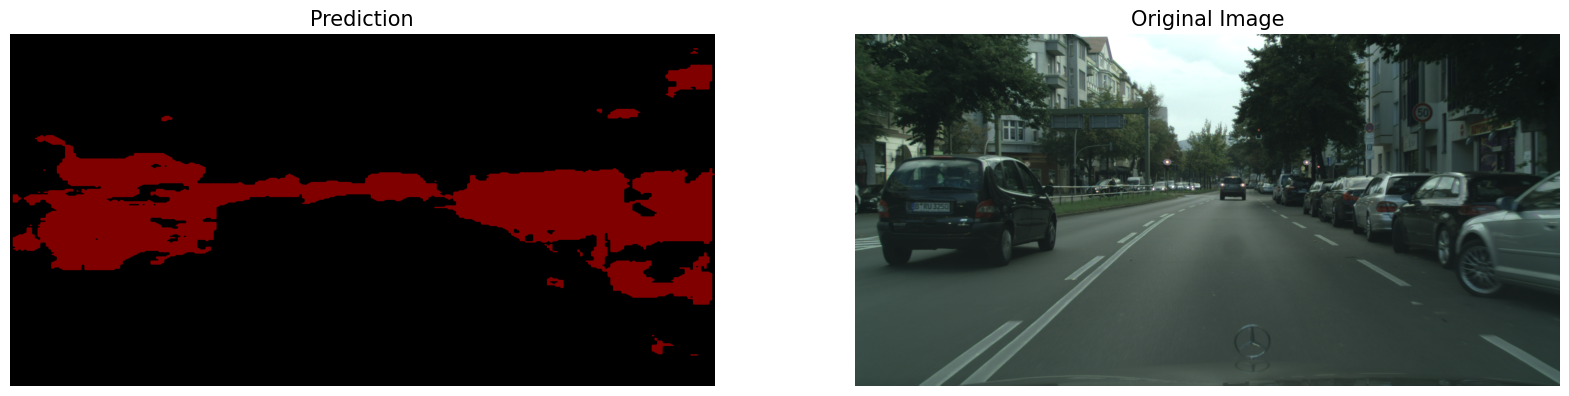

In [37]:
import utils
baseline_simple = tf.keras.models.load_model(
    'baseline_model.keras',
    custom_objects={'dice_loss': dice_loss})

test_gen = utils.seg_gen(image_list, mask_list, batch_size=32)

visualize_keras_prediction(image_list, baseline_simple)

In [38]:

baseline_simple.evaluate(test_gen, return_dict=True)

48/48 ━━━━━━━━━━━━━━━━━━━━ 373s 8s/step - accuracy: 0.0785 - loss: 0.8568 - mean_io_u_1: 0.4119


{'accuracy': 0.08401071280241013,
 'loss': 0.8555504679679871,
 'mean_io_u_1': 0.41416943073272705}

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


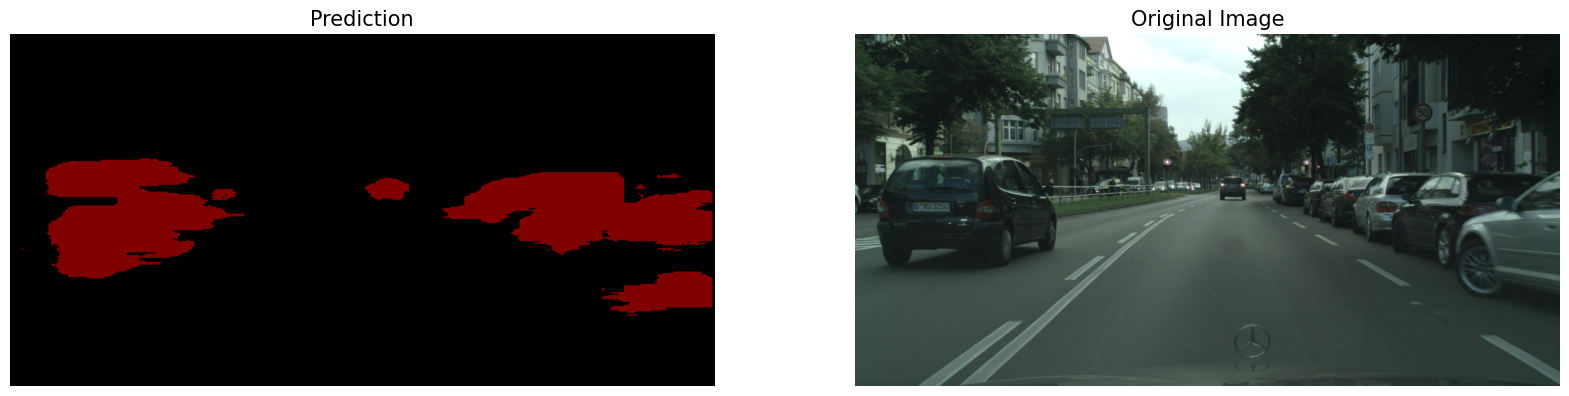

In [27]:
# Baseline visualization
visualize_keras_prediction(image_list, baseline)

### Hybrid visualization

In [ ]:
import tensorflow as tf
hybrid = tf.keras.models.load_model(
    'hybrid_model', custom_objects={'dice_loss': dice_loss})


# hybrid = mlflow.tensorflow.load_model

In [ ]:
keras.layers.TFSMLayer('hybrid_model.keras', call_endpoint='serving_default')

In [ ]:
# Hybrid visualization
visualize_keras_prediction(image_list, hybrid)

## SegFormer model

### Preprocessing

In [39]:
# Creation de test_ds
import io
from datasets import Dataset, DatasetDict, Image
from PIL import Image
from transformers import (
    DefaultDataCollator,
    SegformerFeatureExtractor,
    TFSegformerForSemanticSegmentation)

target_size = (256, 256)
test_ds = {}

for idx, (img_path, mask_path) in enumerate(zip(image_list[:35], mask_list[:35])):
    # Charger l'image et le masque et les redimensionner
    image = Image.open(img_path).convert("RGB").resize(target_size)
    mask = Image.open(mask_path).convert("L").resize(target_size)

    # Créer un élément de dictionnaire avec un index
    test_ds[idx] = {
        'image': image,
        'annotation': mask
    }

# Exemple d'accès au premier élément par son index
print(test_ds[0])


def image_to_byte_array(image: Image):
    img_byte_arr = io.BytesIO()
    # Vous pouvez choisir le format approprié
    image.save(img_byte_arr, format='PNG')
    img_byte_arr = img_byte_arr.getvalue()
    return img_byte_arr


# Appliquer la conversion
for idx in test_ds:
    test_ds[idx]['image'] = image_to_byte_array(test_ds[idx]['image'])
    test_ds[idx]['annotation'] = image_to_byte_array(
        test_ds[idx]['annotation'])


def create_dataset(image_paths, label_paths):
    dataset = Dataset.from_dict({"pixel_values": sorted(image_paths),
                                "label": sorted(label_paths)})
    dataset = dataset.cast_column("pixel_values", Image())
    dataset = dataset.cast_column("label", Image())
    return dataset


{'image': <PIL.Image.Image image mode=RGB size=256x256 at 0x216AD8D7150>, 'annotation': <PIL.Image.Image image mode=L size=256x256 at 0x2180788A810>}


In [48]:
dataset = Dataset.from_dict({"pixel_values": sorted(image_list),
                             "label": sorted(mask_list)})

In [54]:
dataset_dict = DatasetDict({"test": dataset})
print(dataset_dict)

DatasetDict({
    test: Dataset({
        features: ['pixel_values', 'label'],
        num_rows: 1525
    })
})


In [ ]:


test_dataset = create_dataset(image_list, mask_list)

dataset = DatasetDict({"test": test_dataset})

np.array(image.load_img(image_list[0])).shape
original_shape = (1024, 2048)

dataset

### Visualisation

In [62]:
# Utilities function for visualisation
from transformers import SegformerFeatureExtractor
from matplotlib import pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow.keras.utils import load_img
import cv2

feature_extractor = SegformerFeatureExtractor(size=256)


# Supposons que feature_extractor et pretrained_model sont déjà définis et chargés

def transforms(image):
    # Convert image to numpy array and transpose the color channel
    image = tf.keras.utils.load_img(image)
    image = tf.keras.utils.img_to_array(image)
    image = np.transpose(image, (2, 0, 1))
    return image


def preprocess(example_batch):
    # Transform and preprocess the batch of images
    images = [transforms(x.convert("RGB"))
              for x in example_batch["pixel_values"]]
    labels = [x for x in example_batch["label"]]
    inputs = feature_extractor(images, labels)
    return inputs


def normalize_image(image):
    # Normalize image
    image_np = np.array(image)
    normalized_image = (image_np - image_np.min()) / \
        (image_np.max() - image_np.min())
    return normalized_image


def get_seg_overlay(image, seg):

    # Get color overlay on the segmented image using class_colors
    image = np.transpose(image, (1, 2, 0))  # Revert the color channel back
    print(f"Image shape : {np.array(image).shape}")

    # Resize the image to the desired output dimensions (1024, 2048)
    resized_image = cv2.resize(
        image, (2048, 1024), interpolation=cv2.INTER_LINEAR)
    print("Resized image shape:", resized_image.shape)

    color_seg = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8)
    print(f"Color_seg shape : {color_seg.shape}")

    # Apply colors based on the segmentation map
    for label, color in class_colors.items():
        color_seg[seg == label, :] = color
    img = resized_image * 0.5 + color_seg * 0.5
    return img.astype(np.uint8)


def visualize_hf_prediction(test_ds, feature_extractor, pretrained_model):
    # Visualize prediction and the original image
    # i = np.random.randint(0, len(test_ds))
    test_ds.set_transform(preprocess)
    test_image = test_ds['test'][6]["pixel_values"]
    test_gt = test_ds['test'][6]['labels']
    test_image = normalize_image(test_image)

    # Prepare image input for the model prediction
    inputs = feature_extractor(
        images=test_image, return_tensors="tf", do_rescale=False)
    outputs = pretrained_model(**inputs)
    logits = outputs.logits
    logits = tf.transpose(logits, [0, 2, 3, 1])

    # Resize logits to original image size and apply argmax
    upsampled_logits = tf.image.resize(logits, size=(1024, 2048))
    pred_seg = tf.math.argmax(upsampled_logits, axis=-1)[0]

    # Apply label mapping
    pred_seg_mapped = np.vectorize(id2label.get)(pred_seg.numpy())

    print("Unique predicted labels:", np.unique(pred_seg_mapped))

    # Apply color overlay using class_colors palette
    pred_img = get_seg_overlay(test_image, pred_seg_mapped)
    # gt_img = get_seg_overlay(test_image, np.array(test_gt))

    # Print the dimensions to verify
    print(f"Dimensions of the predicted image: {pred_img.shape}")

    # Display the images
    f, axs = plt.subplots(1, 2, figsize=(50, 30))
    axs[0].imshow(pred_img)
    axs[0].set_title("Prediction", fontsize=40)
    axs[0].axis("off")
    axs[1].imshow(load_img(image_list[6], target_size=(1024, 2048)))
    axs[1].set_title("Original Image", fontsize=40)
    axs[1].axis("off")
    plt.show()


id2label = {
    0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 1, 8: 1, 9: 1, 10: 1, 11: 2,
    12: 2, 13: 2, 14: 2, 15: 2, 16: 2, 17: 3, 18: 3, 19: 3, 20: 3, 21: 4,
    22: 4, 23: 5, 24: 6, 25: 6, 26: 7, 27: 7, 28: 7, 29: 7, 30: 7, 31: 7,
    32: 7, 33: 7, 34: 7}

class_colors = {
    0: (0, 0, 0),       # Classe 0 : Noir - Background/Void
    1: (128, 0, 0),     # Classe 1 : Rouge Foncé - Flat
    2: (0, 128, 0),     # Classe 2 : Vert Foncé - Sky
    3: (128, 128, 0),   # Classe 3 : Olive - Human
    4: (0, 0, 128),     # Classe 4 : Bleu Foncé - Vehicle
    5: (128, 0, 128),   # Classe 5 : Pourpre - Object
    6: (0, 128, 128),   # Classe 6 : Teal - Construction
    7: (128, 128, 128)  # Classe 7 : Gris - Nature
}

C:\Users\clema\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\models\segformer\feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(


Unique predicted labels: [0 1 2 3 4 5 6 7]
Image shape : (256, 256, 3)
Resized image shape: (1024, 2048, 3)
Color_seg shape : (1024, 2048, 3)
Dimensions of the predicted image: (1024, 2048, 3)


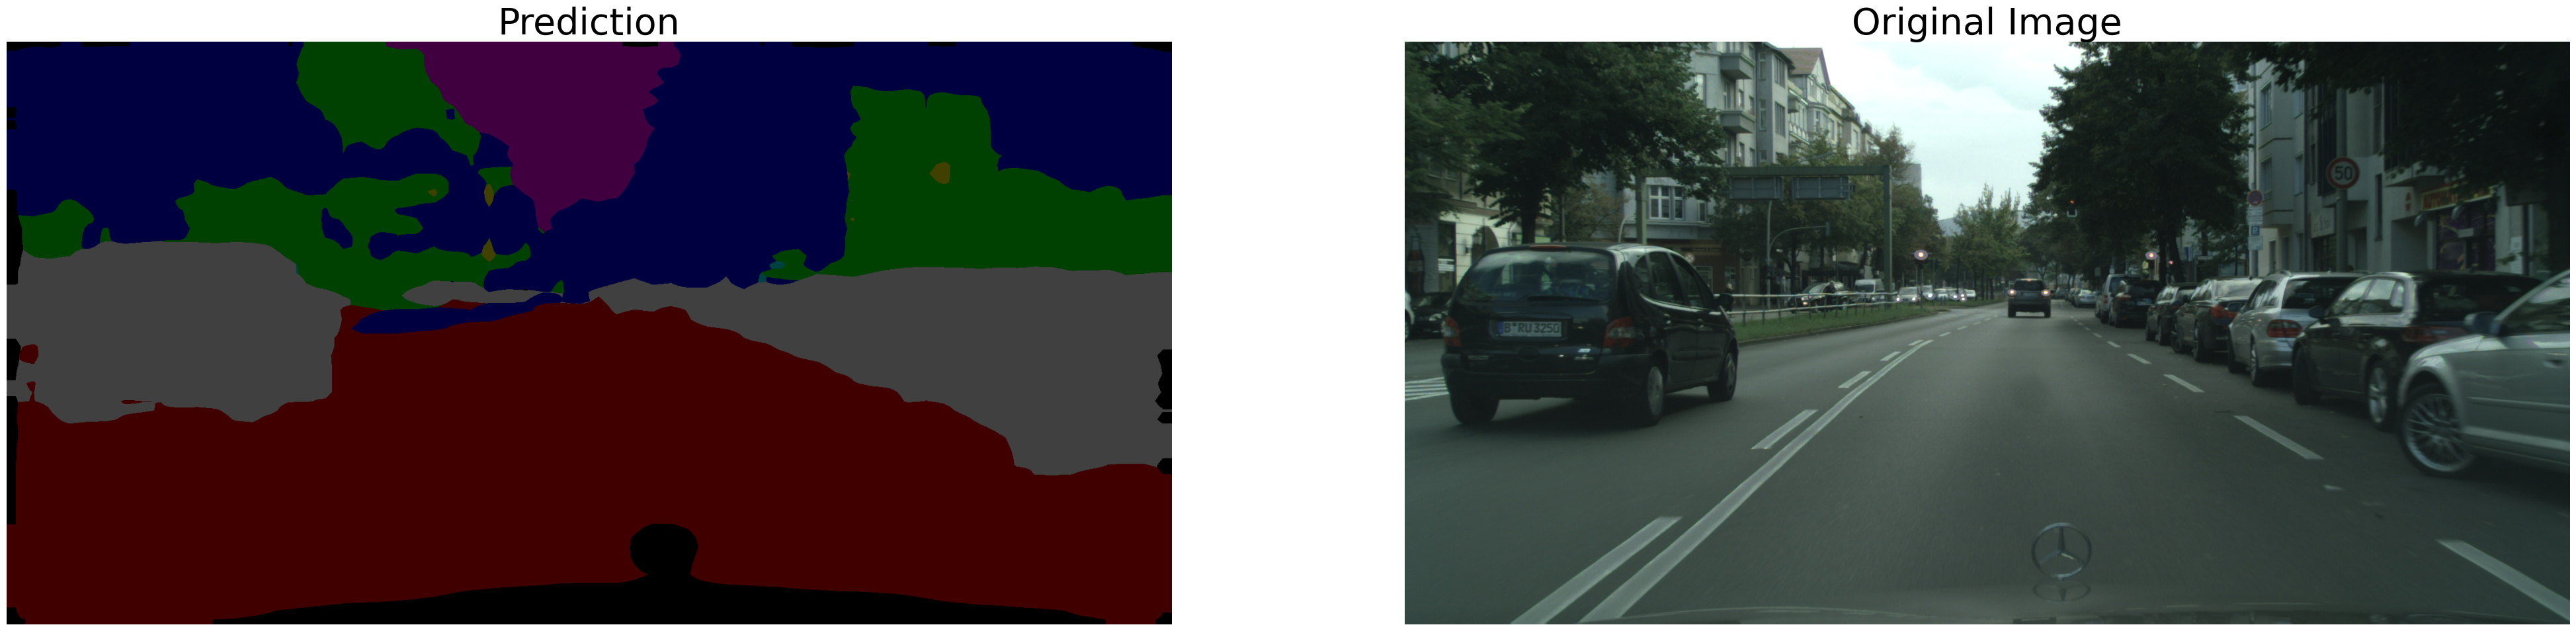

In [82]:
# Example usage
visualize_hf_prediction(dataset, feature_extractor, hf_model)

# Metrics evaluation

## baseline

In [39]:
# Conversion de la fonction dice_loss en métrique pour l'évaluation
@register_keras_serializable()
def dice_loss(y_true, y_pred, smooth=1e-6):
    """
   Fonction de perte de Dice pour la segmentation sémantique.
    Args:
    y_true (tensor): Tensor des étiquettes réelles.
    y_pred (tensor): Tensor des prédictions du modèle.
    smooth (float): Terme de lissage pour éviter la division par zéro.
    Returns:
    float: Perte de Dice.
    """

    # Aplatir les tensors

    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2])

    union = tf.reduce_sum(
        y_true, axis=[1, 2]) + tf.reduce_sum(y_pred, axis=[1, 2])

    dice = (2. * intersection + smooth) / (union + smooth)

    dice_loss = 1 - tf.reduce_mean(dice, axis=-1)

    return dice_loss


def dice_metric(y_true, y_pred):
    return 1 - dice_loss(y_true, y_pred)


# Préparation des métriques
metrics = [
    tf.metrics.MeanIoU(num_classes=8),
    tf.metrics.Accuracy()
]


baseline.compile(
    optimizer='adam',  # Vous pouvez choisir l'optimiseur selon vos besoins
    loss=dice_loss,    # Utiliser la perte personnalisée
    metrics=metrics)

print("-------------------------------------------------------------")

-------------------------------------------------------------


In [40]:

baseline.evaluate(test_gen, return_dict=True)

C:\Users\clema\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


48/48 ━━━━━━━━━━━━━━━━━━━━ 392s 8s/step - accuracy: 0.5950 - loss: 0.7334 - mean_io_u_3: 0.4051


{'accuracy': 0.5963946580886841,
 'loss': 0.7330902814865112,
 'mean_io_u_3': 0.4052448272705078}

Modèle baseline evaluation score :
* **accuracy**: 59,64%
* **loss**: 73,31%,
* **meanIoU**: 40,52%

## HF model

In [43]:
hf_model = TFSegformerForSemanticSegmentation.from_pretrained(
    'Modèles/Data Augmentation/HF_model')

All model checkpoint layers were used when initializing TFSegformerForSemanticSegmentation.

All the layers of TFSegformerForSemanticSegmentation were initialized from the model checkpoint at Modèles/Data Augmentation/HF_model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFSegformerForSemanticSegmentation for predictions without further training.


In [73]:
dataset

Dataset({
    features: ['pixel_values', 'label'],
    num_rows: 1525
})

In [69]:
from PIL import Image


def preprocess(example_batch):
    # Charger et convertir chaque image du chemin à PIL Image et convertir en RGB
    images = [Image.open(x).convert("RGB")
              for x in example_batch["pixel_values"]]
    # Convertir chaque PIL Image en numpy array
    images = [np.array(img) for img in images]
    # Puisqu'on a une liste de numpy arrays, vous pouvez les empiler pour former un seul numpy array si nécessaire :
    # Uniquement si votre modèle attend un batch sous cette forme
    images = np.stack(images)
    labels = example_batch["label"]
    # Maintenant, passons ce numpy array au feature_extractor ou à toute autre fonction de traitement
    # Assurez-vous que le feature_extractor ou la fonction de traitement peut gérer ce format
    inputs = feature_extractor(images, labels)
    return inputs


dataset_dict['test'] = preprocess(dataset)


test_ds = dataset_dict['test']


data_collator = DefaultDataCollator(return_tensors="tf")



print("OK.Conversion en tf_dataset...")


test_set = test_ds.to_tf_dataset(  #
    columns=["pixel_values", "label"],
    shuffle=False,
    batch_size=batch_size,
    collate_fn=data_collator,
)


print("OK. Vérification :", test_set.element_spec)

KeyboardInterrupt: 

In [45]:
test_set

<_PrefetchDataset element_spec={'labels': TensorSpec(shape=(None, 256, 256), dtype=tf.int64, name=None), 'pixel_values': TensorSpec(shape=(None, 3, 256, 256), dtype=tf.float32, name=None)}>

In [ ]:
import numpy as np
from datasets import load_metric

# Charger les métriques
accuracy_metric = load_metric("accuracy")
mean_iou_metric = load_metric("mean_iou")

# Préparer les listes pour les prédictions et les labels réels
all_predictions = []
all_labels = []

# Itérer sur le dataset
for batch in test_set:
    # Effectuer la prédiction
    outputs = hf_model(batch["pixel_values"])
    logits = outputs.logits
    predictions = tf.math.argmax(logits, axis=-1)

    # Ajouter les prédictions et les labels à la liste
    all_predictions.extend(predictions.numpy().flatten())
    all_labels.extend(batch["labels"].numpy().flatten())

# Calcul des métriques sur les prédictions complètes
accuracy = accuracy_metric.compute(
    predictions=all_predictions, references=all_labels)
mean_iou = mean_iou_metric.compute(
    predictions=all_predictions, references=all_labels, num_labels=34)

print(f"Accuracy: {accuracy['accuracy']}")
print(f"Mean IoU: {mean_iou['mean_iou']}")

In [35]:
# Nettoyage des fichiers desktop.ini créés en local
# A effectuer avant toute visualisation
import glob
import os

# Définir le chemin de base où rechercher les fichiers `desktop.ini`
base_path = "mlruns/**/desktop.ini"

# Utiliser `glob.glob` avec l'option `recursive=True` pour trouver tous les fichiers correspondants
# dans le dossier et ses sous-dossiers.
desktop_ini_files = glob.glob(base_path, recursive=True)

# Parcourir la liste des chemins de fichiers trouvés et les supprimer
for file_path in desktop_ini_files:
    os.remove(file_path)
    print(f"Deleted: {file_path}")

# Note: Assurez-vous que le chemin `base_path` est correct et que vous souhaitez supprimer ces fichiers
# avant d'exécuter le script.

Deleted: mlruns\656098689017539736\0b3050f457e945199b647b39bd6241f0\artifacts\checkpoints\desktop.ini
Deleted: mlruns\656098689017539736\0b3050f457e945199b647b39bd6241f0\artifacts\model\desktop.ini
Deleted: mlruns\656098689017539736\0b3050f457e945199b647b39bd6241f0\artifacts\model\data\desktop.ini
Deleted: mlruns\656098689017539736\0b3050f457e945199b647b39bd6241f0\artifacts\tensorboard_logs\desktop.ini
Deleted: mlruns\656098689017539736\0b3050f457e945199b647b39bd6241f0\artifacts\tensorboard_logs\train\desktop.ini
Deleted: mlruns\656098689017539736\0b3050f457e945199b647b39bd6241f0\artifacts\tensorboard_logs\validation\desktop.ini
